DSCI 100 Project

name: Ryan Cheng 

student ID: 53355756

# Libraries/ setting

In [1]:
# libraries / plot setting /seed
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(dplyr)
library(tidyr)
library(ggplot2)
options(repr.plot.width = 11, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
set.seed(4100) #used seed "4100"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

This is a data science project with real data collect via a minecraft server created by a research group in Computer Science led by Frank Wood. 

The research group is interested about how people play video games. Thus ther created this minecraft server and recorded players' actions as they play through the game. They provided three questions for us to pick one to answer and the second question is selected for this project. 

Question to answer: 

    Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

In [26]:
#Read the data from the data folder
players <- read_csv("data/players.csv")|>
    as.data.frame()|>
    mutate(subscribe = as.factor(subscribe))|>
    mutate(age = Age)|>
    select(-Age)# make the subscribe column a factor instead of "lgl"


head(players) #used head as there are too many rows
nrow(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,experience,subscribe,hashedEmail,played_hours,name,gender,age
,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196

After reading the data, it seems like the session time data is not really helpful to answer the question, thus the focus will be on the players data. 

In the players data, there are 196 rows and 7 columns. The columns are:
- experience (indicates the skill level of the players)
- subscribe (showing does the player subscribe to game related newsletter)
- hashedEmail
- played_hours (show how many hours a player had played in the server)
- name
- gender
- age

Hashed email and names is not really helpful to determine what kind of players will contributor a lot of data, because these are too specific. 

In [3]:
# session <- read_csv("data/session.csv")|>
#     as.data.frame()
# head(session)
##not useful for this question

# Methods

In order to find out which "kinds" of players are most likely to contribute a large amount of data, we will need to perform a regression problem to find out what amount of time should be "large amount of data" in this dataset. Then, we can just filter out those who have contributed for a large amount of data and find out what kind of players they are. 

Before we start the regression, we should take a look at the relationships between the varibles and decide which type of regression model should we use. 



Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


NULL

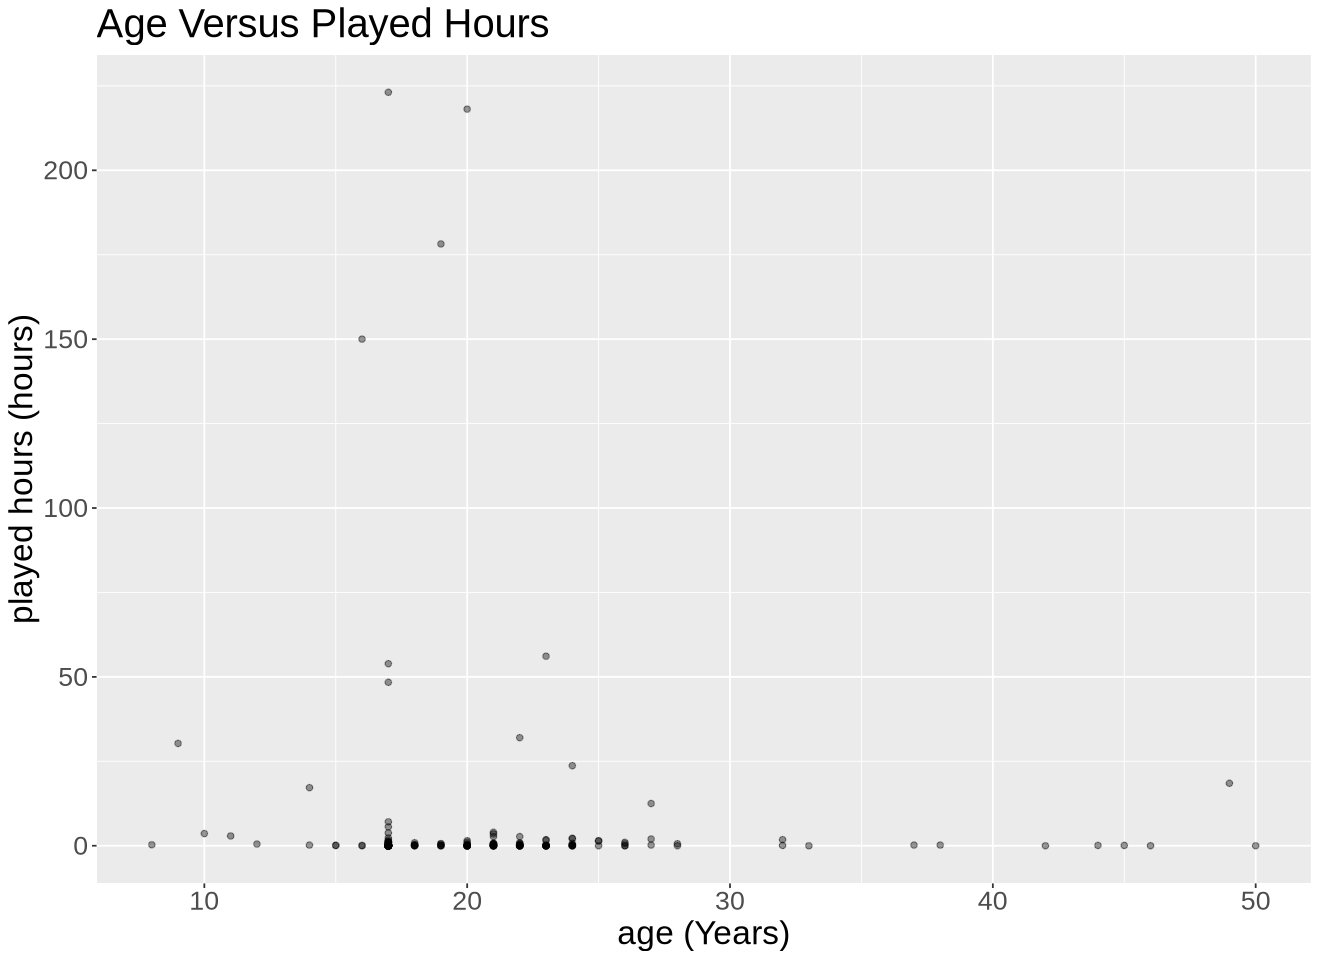

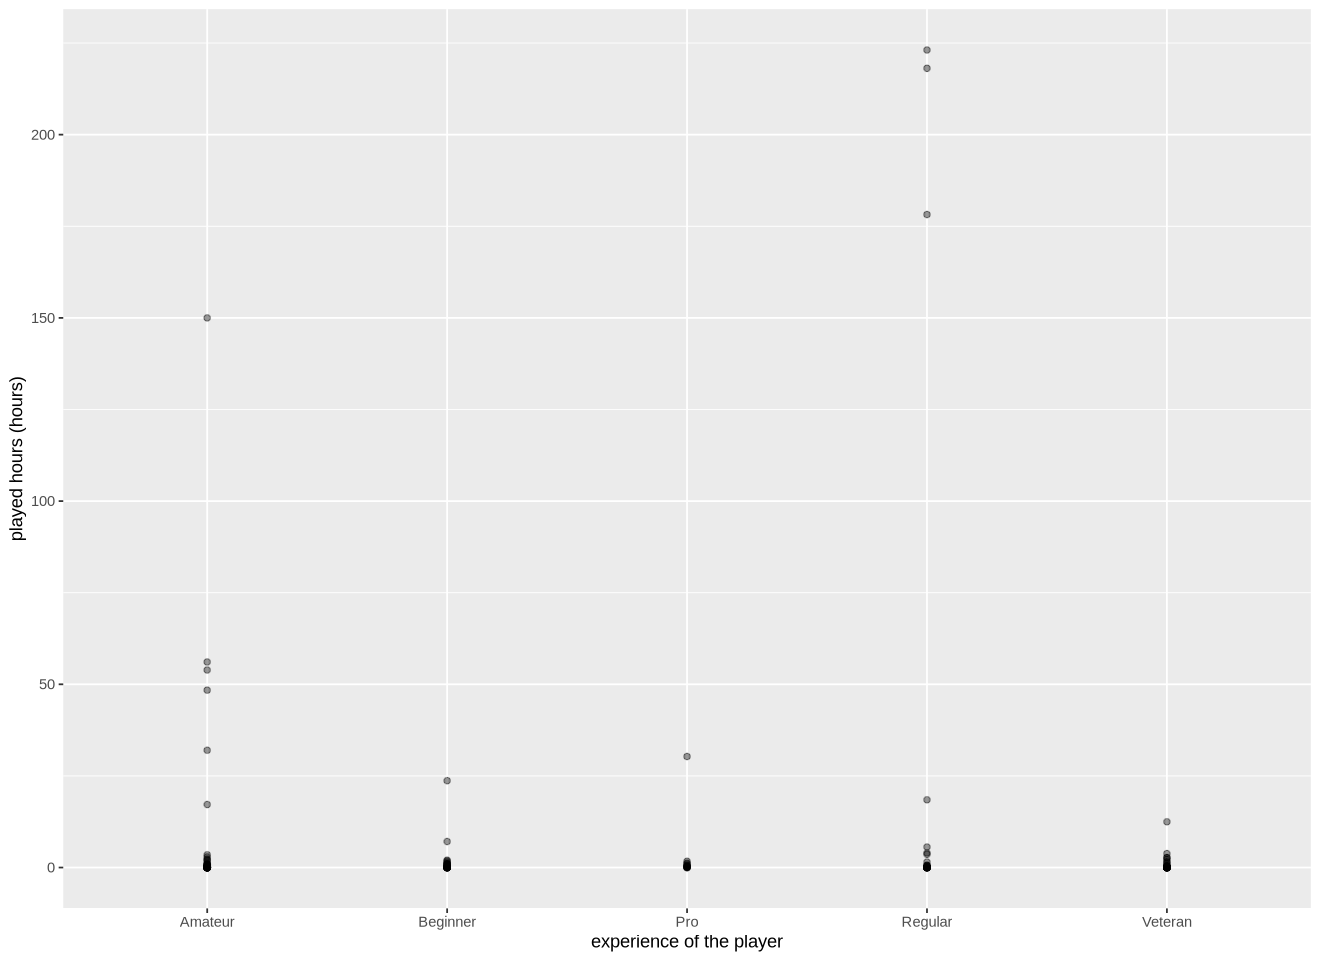

In [28]:

players_age_plot <- players|>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4)+
    ylab("played hours (hours)")+
    xlab("age (Years)")+
    ggtitle("Age Versus Played Hours")+
theme(text = element_text(size = 20))
players_age_plot  

players_experience_plot <- players|>
    ggplot(aes(x = experience, y = played_hours)) +
    geom_point(alpha = 0.4)+
    ylab("played hours (hours)")+
    xlab("experience of the player")
    ggtitle("Played Hours Versus Experience of the Player ")+
theme(text = element_text(size = 20))
players_experience_plot  
players <- players|>
    mutate(experience = case_when(
    experience == "Beginner" ~ 1,
    experience == "Amateur"  ~ 2,
    experience == "Regular"  ~ 3,
    experience == "Veteran"  ~ 5,
    experience == "Pro"      ~ 4,))#quantify the experience value 



Looking at the two plots, it doesn't seem like there is any strong linear relationship between the varibles. Thus, k-nearest neighbors regression will be used to solve this problem.  

# Model

First, we should spilt the data into a training part and a testing part. The training part will be 75% of the data and the testing part will be 25%. 

In [5]:
set.seed(4100)
players_split <- initial_split(players, prop = 0.75, strata = played_hours) #spliting the players data
players_training <- training(players_split)
players_testing <- testing(players_split)

In [6]:
set.seed(4100)
#create a recipe that predicts played hours with the varibles and scale the data
player_recipe <- recipe(played_hours ~ experience + age, data = players_training)|>
    step_scale(all_predictor())|>
    step_center(all_predictor())
#create a model specification for k-nearest neighbors regression
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")
#use 5- fold cross validation to find the best k value
player_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

player_workflow <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec)

We will run cross validation for grid numbers of 1 to 50

In [7]:
set.seed(4100)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

player_result <- player_workflow|>
    tune_grid(resamples = player_vfold, grid = k_vals)|>
    collect_metrics()|>
     filter(.metric =="rmse")
player_result

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,48.46893,4,10.047412,Preprocessor1_Model01
2,rmse,standard,42.04805,4,3.680821,Preprocessor1_Model02
3,rmse,standard,38.80399,4,3.344265,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,rmse,standard,35.14766,4,2.823733,Preprocessor1_Model48
49,rmse,standard,35.02180,4,2.876861,Preprocessor1_Model49
50,rmse,standard,34.79867,4,2.919611,Preprocessor1_Model50


In [8]:
player_min <- player_result|>
    filter(mean == min(mean))
player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,33.5521,4,2.207133,Preprocessor1_Model14


It seems like k = 14 will give us the lowest RMSE. 

# Result

In [17]:
set.seed(4100)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14)|>
    set_engine("kknn")|>
    set_mode("regression")

player_fit <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(players_spec)|>
    fit(data = players_training)

players_testing_clean <- players_testing %>% drop_na()


player_summary <- player_fit|>
    predict(players_testing_clean)|>
    bind_cols(players_testing_clean)|>
    metrics(truth = played_hours, estimate = .pred)|>
    filter(.metric == "rmse")
player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,14.29428


Therefore, a large amount of data in this data set is any played time above 14.3 hours. As mentioned above, we need to filter out those players and find what kind of players are they

In [18]:
large_data <- player_summary|>
    select(.estimate)|>
    pull()

player_filtered <- players|>
    filter(played_hours > large_data)|>
    mutate(experience = factor(experience,
                                   levels = 1:5,
                                   labels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) # we don't need the numbers anymore
player_filtered
#nrow(player_filtered)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Amateur,TRUE,a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,48.4,Xander,Female,17
Regular,TRUE,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,218.1,Akio,Non-binary,20
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Beginner,TRUE,9782452b8e41d1f140374eec34c84f464df6ed12e2777e5b4f7150912b8ab78c,23.7,Isla,Male,24
Regular,TRUE,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,178.2,Piper,Female,19
Amateur,TRUE,24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,32.0,Sidney,Male,22


Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


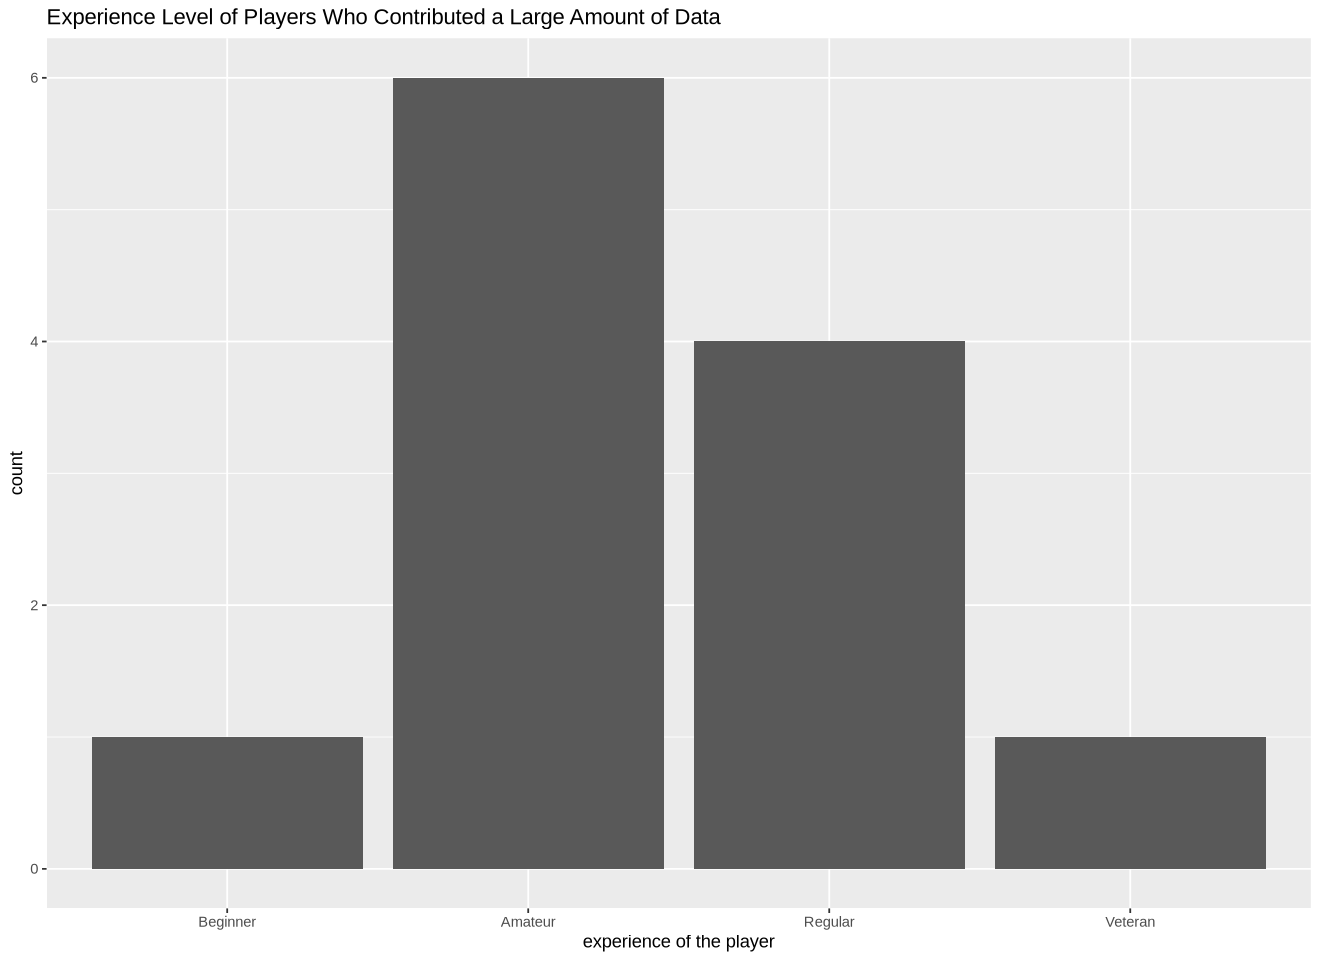

In [11]:
large_contributor_experience_plot <- player_filtered|>
    ggplot(aes(x = experience))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "experience of the player")+
    ggtitle("Players Who Contributed a Large Amount of Data Experience Level")
large_contributor_experience_plot

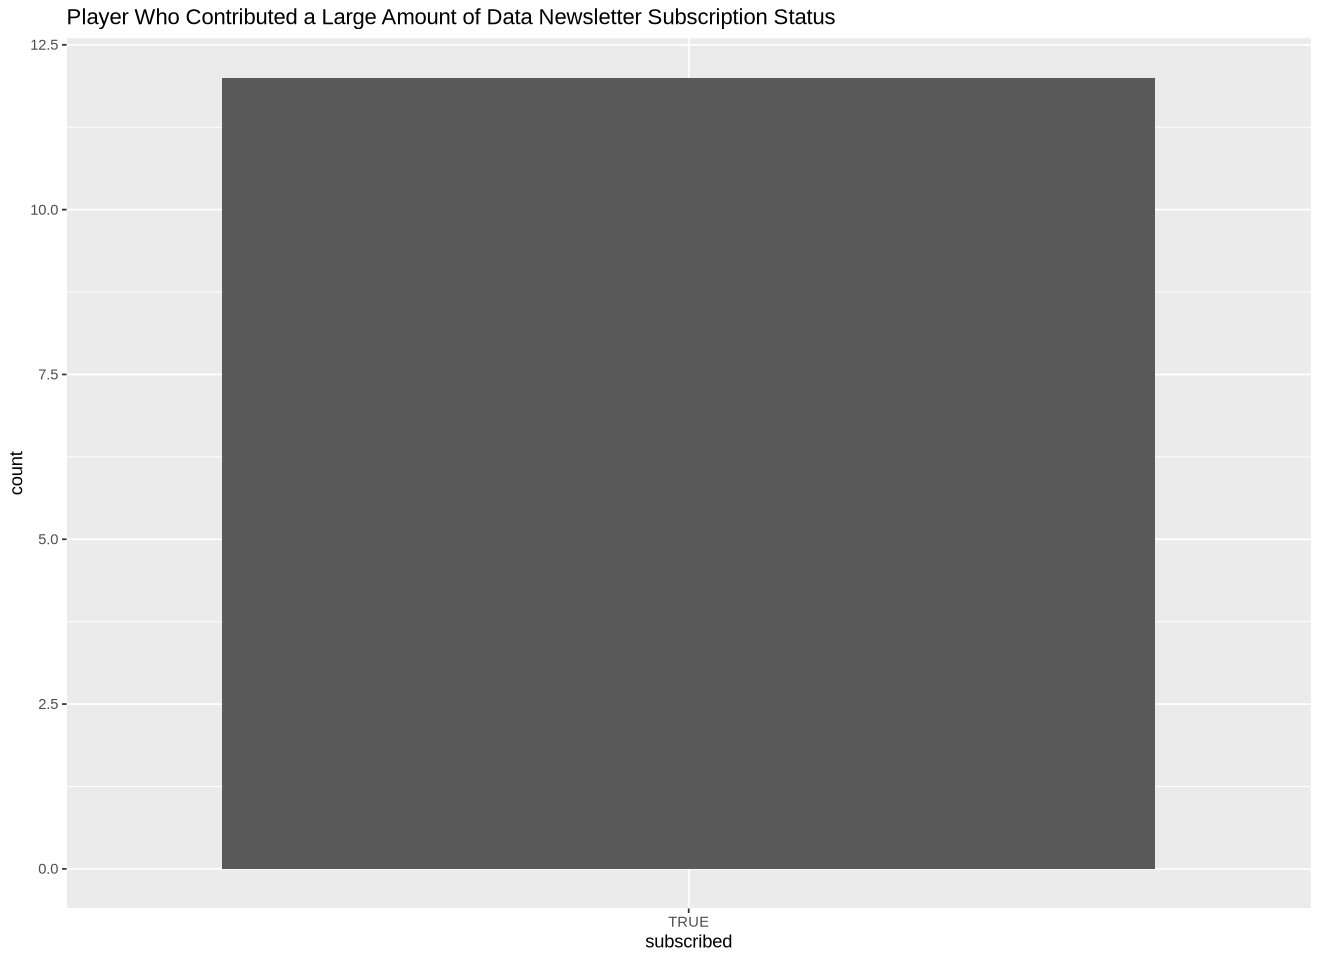

In [12]:
large_contributor_subscribe_plot <- player_filtered|>
    ggplot(aes(x = subscribe))+
    geom_bar()+
    labs(x = "subscribed", y = "count")+
    ggtitle("Player Who Contributed a Large Amount of Data Newsletter Subscription Status")
large_contributor_subscribe_plot

Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


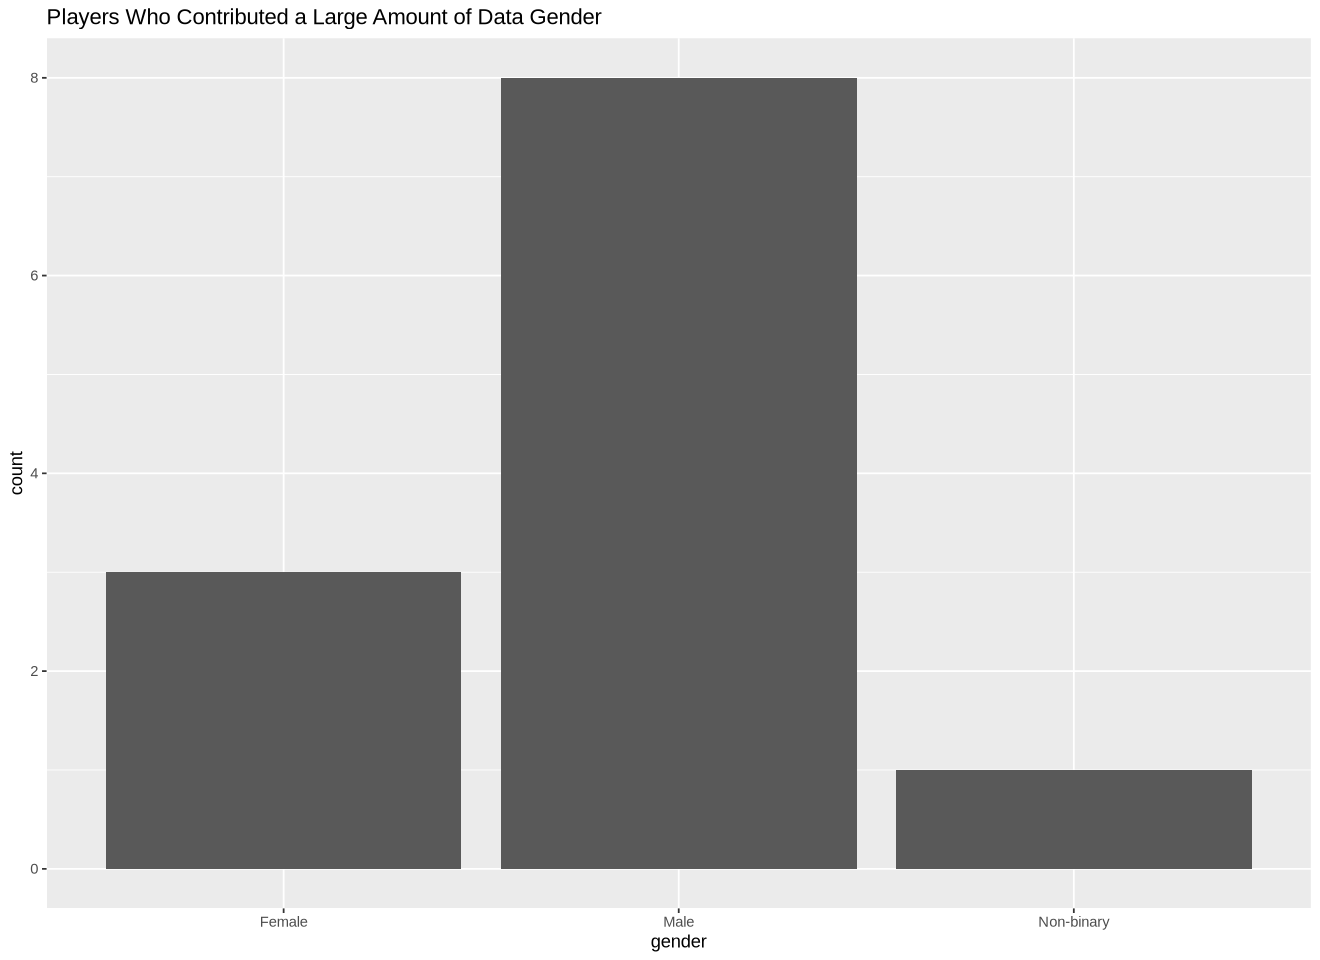

In [13]:
large_contributor_gender_plot <- player_filtered|>
    ggplot(aes(x = gender))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "gender")+
    ggtitle("Players Who Contributed a Large Amount of Data Gender")
large_contributor_gender_plot

Warning message in geom_histogram(stat = "count", binwidth = 1):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


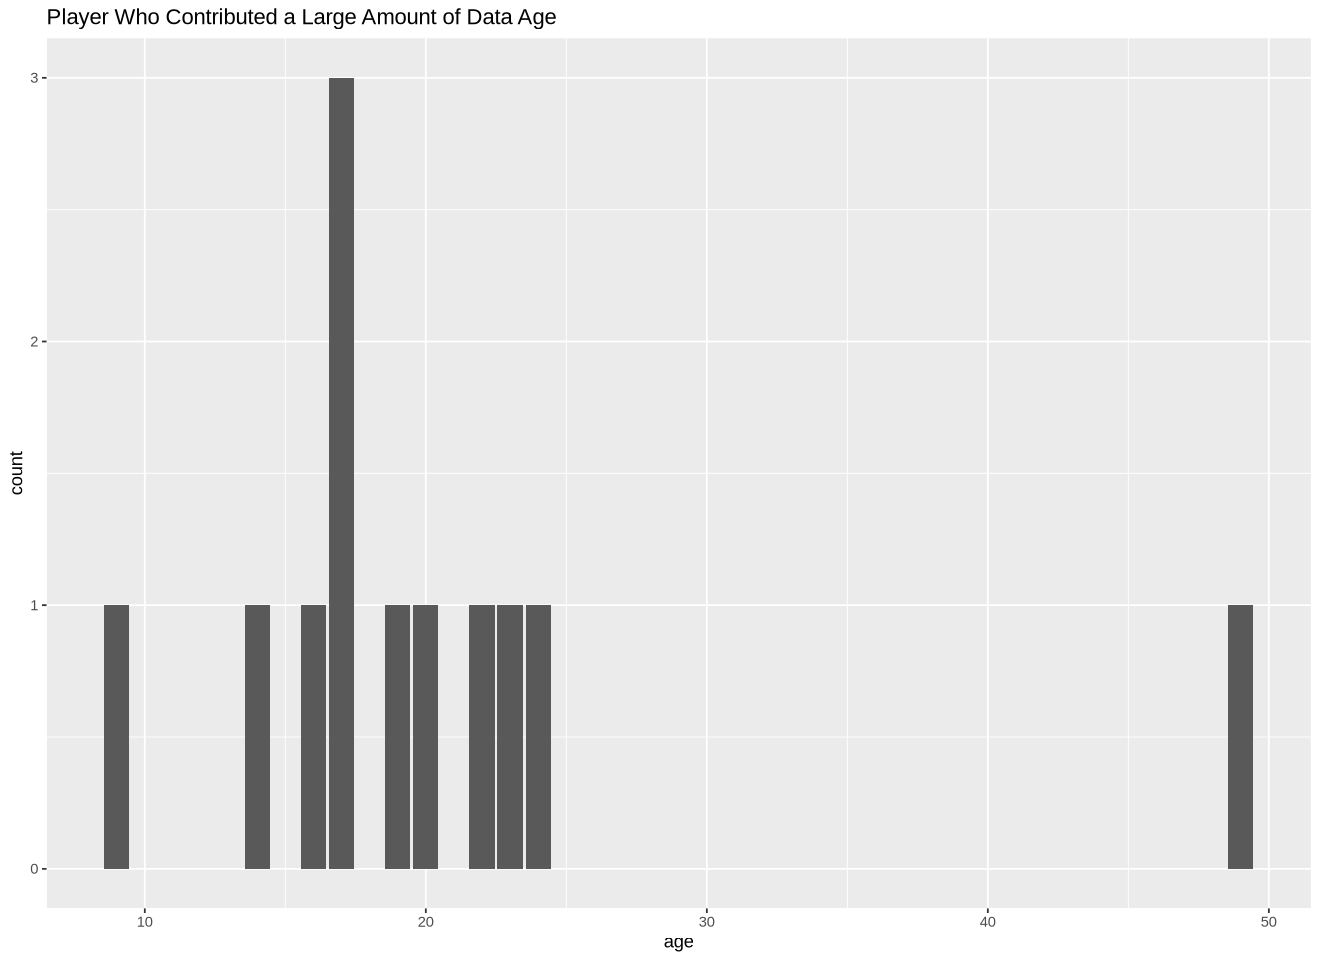

In [14]:
large_contributor_age_plot <- player_filtered|>
    ggplot(aes(x = age))+
    geom_histogram(stat= "count", binwidth = 1)+
    labs(x = "age")+
    ggtitle("Player Who Contributed a Large Amount of Data Age")
large_contributor_age_plot

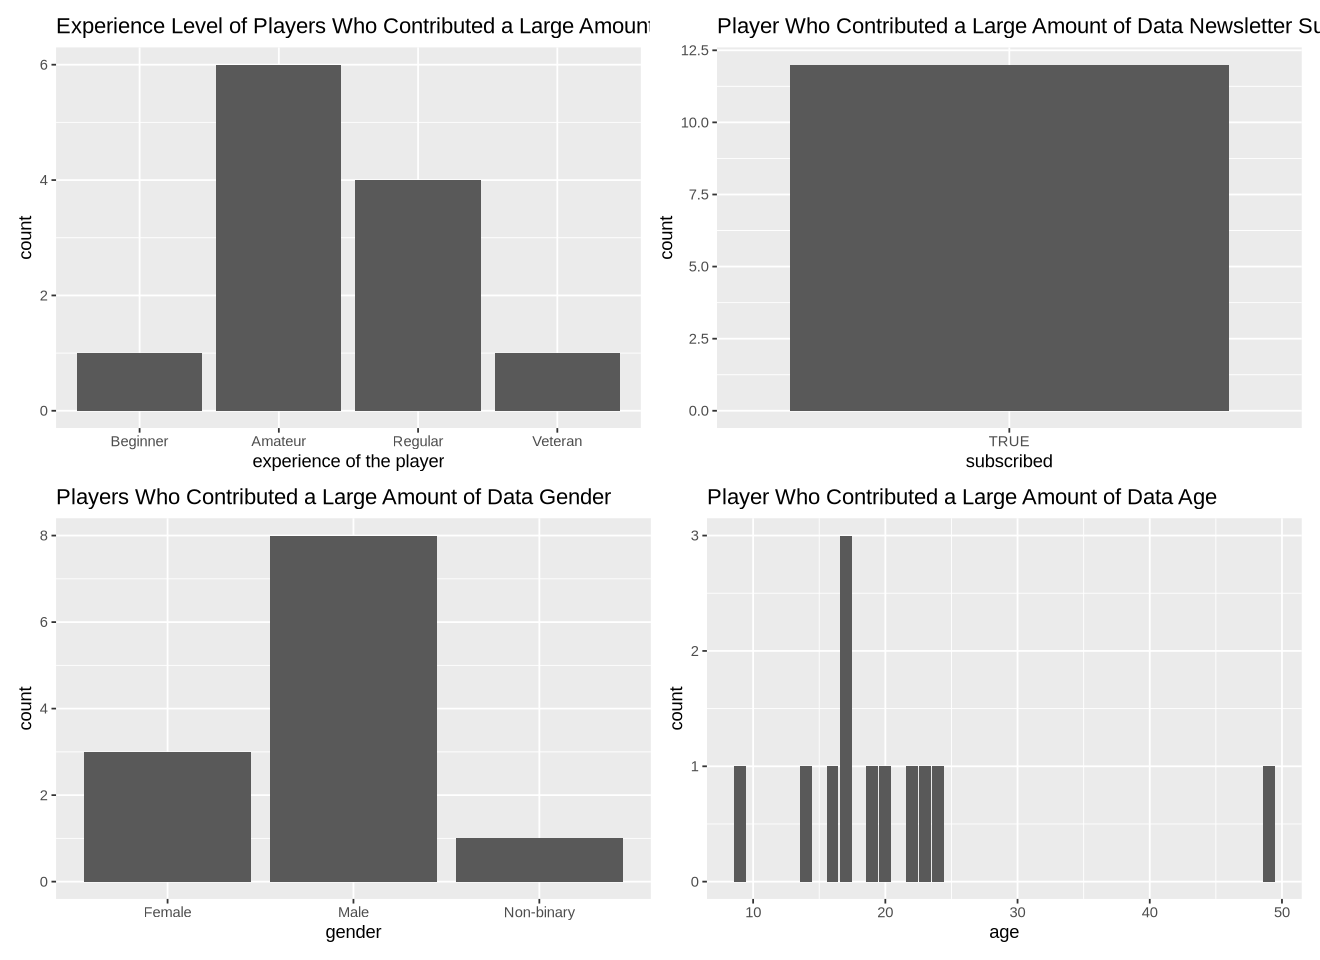

In [16]:
library(patchwork)
(large_contributor_experience_plot|large_contributor_subscribe_plot)/(large_contributor_gender_plot|large_contributor_age_plot)

# Discussion

Looking at the plot, it is shown that players who are male, subscribed to a game related newsletter, at have an amateur/regular experience of the game, and 17 years old are most likely to be contributing a large amount of data. This is not really suprising because minecraft is genuinely most popular amoung teenage male players. The one interesting discouvery is that "good" players (pros and Veterans) are not really playing a lot of hours. One possible explaination to this phenomeno is maybe those "good" players found this server too simply and boring, they would rather spend more time on hypixel or their own server. 